# Zillow Zestimates Errors

By AJ Martinez

In [72]:
# import usual libraries needed
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# import from local libraries
import env
from wrangle import * 

# import tools for modeling
from scipy import stats
from sklearn.feature_selection import  SelectKBest, RFE, f_regression, SequentialFeatureSelector
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

alpha = .05

import warnings
warnings.filterwarnings('ignore')

## Project Goal

- The goal of this project is to find the drivers of zestimate errors
- Deliver a report that the data science team can read through and replicate, understand what steps were taken, why and what the outcome was.
- Make recommendations on what works or doesn't work in prediction of zestimate errors

## Project Description

"Zestimates" are estimated home values based on 7.5 million statistical and machine learning models that analyze hundreds of data points on each property. And, by continually improving the median margin of error (from 14% at the onset to 5% today), Zillow has since become established as one of the largest, most trusted marketplaces for real estate information in the U.S. and a leading example of impactful machine learning.

Finding the driver of errors will better the performance and customer satisfaction.

## Initial Questions

- Is there a relationship between Log Error and Zip Code?
- Is there a relationship between Log Error and Square Footage?
- Is there a relationship between Log Error and Tax Value?
- Is there a relationship between Log Error and Latitude?

## Data Dictionary

|Variable|Description|
|---|---|
| parcelid  | Parcel Identification Number  |       
| bathroomcnt | Number of Bathrooms|
| bedroomcnt  | Number of Bedrooms|
| calculatedfinishedsquarefeet | Property Square Footage|
| fips | Federal Information Processing Standard  |
| latitude | Latitude|               
| longitude | Longitude|      
| lotsizesquarefeet | Lot Square Footage |
| regionidcounty | County Region Identification|           
| regionidzip | Zip Code |
| yearbuilt | Year Property was built|
| structuretaxvaluedollarcnt | Structure Tax Value|
| taxvaluedollarcnt | Property Tax Value |
| landtaxvaluedollarcnt | Land Tax Value|
| taxamount | Tax Paid|
| logerror | Zestimate error|
| transactiondate | Transaction date|
| propertylandusedesc | Land Use Description |
| county | County |

## Wrangle Zillow Data

### Acquire Zillow Data 

Acquire zillow data from mySQL into a single dataframe. The function has an SQL query that can be found on the wrangle notebook. The query will combine all 8 tables in the Zillow database. Since the query can take a long time, this function also saves the dataframe into a csv for faster access.

In [27]:
df = get_zillow_data()
df.head()

Reading from csv file...


,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,taxdelinquencyyear,censustractandblock,logerror,transactiondate,typeconstructiondesc,airconditioningdesc,architecturalstyledesc,buildingclassdesc,propertylandusedesc,storydesc
0,1727539,14297519,NaN,NaN,NaN,3.5,4.0,NaN,NaN,3.5,...,NaN,6.059063e+13,0.025595,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN
1,1387261,17052889,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1.0,...,NaN,6.111001e+13,0.055619,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN
2,11677,14186244,NaN,NaN,NaN,2.0,3.0,NaN,NaN,2.0,...,NaN,6.059022e+13,0.005383,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN
3,2288172,12177905,NaN,NaN,NaN,3.0,4.0,NaN,8.0,3.0,...,NaN,6.037300e+13,-0.103410,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN
4,1970746,10887214,1.0,NaN,NaN,3.0,3.0,NaN,8.0,3.0,...,NaN,6.037124e+13,0.006940,2017-01-01,NaN,Central,NaN,NaN,Condominium,NaN


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77574 entries, 0 to 77573
Data columns (total 67 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            77574 non-null  int64  
 1   parcelid                      77574 non-null  int64  
 2   airconditioningtypeid         25006 non-null  float64
 3   architecturalstyletypeid      206 non-null    float64
 4   basementsqft                  50 non-null     float64
 5   bathroomcnt                   77574 non-null  float64
 6   bedroomcnt                    77574 non-null  float64
 7   buildingclasstypeid           15 non-null     float64
 8   buildingqualitytypeid         49808 non-null  float64
 9   calculatedbathnbr             76959 non-null  float64
 10  decktypeid                    614 non-null    float64
 11  finishedfloor1squarefeet      6035 non-null   float64
 12  calculatedfinishedsquarefeet  77374 non-null  float64
 13  f

In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,77574.0,1.495340e+06,8.609689e+05,3.490000e+02,7.520875e+05,1.498169e+06,2.240588e+06,2.982274e+06
parcelid,77574.0,1.300630e+07,3.478043e+06,1.071186e+07,1.153819e+07,1.253050e+07,1.421124e+07,1.676893e+08
airconditioningtypeid,25006.0,1.812045e+00,2.965823e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.300000e+01
architecturalstyletypeid,206.0,7.388350e+00,2.734542e+00,2.000000e+00,7.000000e+00,7.000000e+00,7.000000e+00,2.100000e+01
basementsqft,50.0,6.797200e+02,6.897035e+02,3.800000e+01,2.730000e+02,5.150000e+02,7.965000e+02,3.560000e+03
bathroomcnt,77574.0,2.298521e+00,9.967057e-01,0.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,1.800000e+01
bedroomcnt,77574.0,3.053252e+00,1.140447e+00,0.000000e+00,2.000000e+00,3.000000e+00,4.000000e+00,1.600000e+01
buildingclasstypeid,15.0,3.933333e+00,2.581989e-01,3.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00
buildingqualitytypeid,49808.0,6.533830e+00,1.722041e+00,1.000000e+00,6.000000e+00,6.000000e+00,8.000000e+00,1.200000e+01
calculatedbathnbr,76959.0,2.316389e+00,9.796902e-01,1.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,1.800000e+01


In [5]:
df.isnull().sum().sort_values(ascending=False)[:45]

buildingclassdesc           77559
buildingclasstypeid         77559
finishedsquarefeet13        77532
storydesc                   77524
storytypeid                 77524
basementsqft                77524
yardbuildingsqft26          77504
fireplaceflag               77402
architecturalstyletypeid    77368
architecturalstyledesc      77368
typeconstructiontypeid      77352
typeconstructiondesc        77352
finishedsquarefeet6         77188
pooltypeid10                77109
decktypeid                  76960
poolsizesum                 76705
pooltypeid2                 76500
hashottuborspa              76035
yardbuildingsqft17          75181
taxdelinquencyyear          74674
taxdelinquencyflag          74674
finishedsquarefeet15        74547
finishedsquarefeet50        71539
finishedfloor1squarefeet    71539
fireplacecnt                69287
threequarterbathnbr         67469
pooltypeid7                 62496
poolcnt                     61401
numberofstories             59978
airconditionin

### Takeaways:
- lots of null values
- multiple columns with very liitle input
- multiple columns with similar information
- select only single family structures

### Addressing the nulls

In [6]:
# This funtion gives the nulls by column
nulls_by_col(df)

,number_missing_rows,percent_rows_missing
id,0,0.000000
parcelid,0,0.000000
airconditioningtypeid,52568,0.677650
architecturalstyletypeid,77368,0.997344
basementsqft,77524,0.999355
...,...,...
airconditioningdesc,52568,0.677650
architecturalstyledesc,77368,0.997344
buildingclassdesc,77559,0.999807
propertylandusedesc,0,0.000000


In [15]:
# This funtion gives the nulls by row
nulls_by_row(df)

,num_cols_missing,num_rows,pct_cols_missing
0,23,4,0.343284
1,24,14,0.358209
2,25,34,0.373134
3,26,129,0.388060
4,27,498,0.402985
5,28,619,0.417910
6,29,5328,0.432836
7,30,3963,0.447761
8,31,11549,0.462687
9,32,13790,0.477612


#### Using the handle missing values function to drop over 50% nulls rows and columns.
- Went from 77,574 to 49,990 rows
- From 67 to 29 columns
- The highest percent of rows nulls went from 70% to 14%
- The highest percent of columns nulls went from 99% to 3%

In [16]:
handle_missing_values(df)

,id,parcelid,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,latitude,...,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,transactiondate,propertylandusedesc
1,1387261,17052889,1.0,2.0,1.0,1465.0,1465.0,6111.0,1.0,34449266.0,...,1967.0,88000.0,464000.0,2016.0,376000.0,5672.48,6.111001e+13,0.055619,2017-01-01,Single Family Residential
2,11677,14186244,2.0,3.0,2.0,1243.0,1243.0,6059.0,2.0,33886168.0,...,1962.0,85289.0,564778.0,2016.0,479489.0,6488.30,6.059022e+13,0.005383,2017-01-01,Single Family Residential
3,2288172,12177905,3.0,4.0,3.0,2376.0,2376.0,6037.0,3.0,34245180.0,...,1970.0,108918.0,145143.0,2016.0,36225.0,1777.51,6.037300e+13,-0.103410,2017-01-01,Single Family Residential
4,1970746,10887214,3.0,3.0,3.0,1312.0,1312.0,6037.0,3.0,34185120.0,...,1964.0,73681.0,119407.0,2016.0,45726.0,1533.89,6.037124e+13,0.006940,2017-01-01,Condominium
5,1447245,17143294,2.0,3.0,2.0,1492.0,1492.0,6111.0,2.0,34230044.0,...,1982.0,198640.0,331064.0,2016.0,132424.0,3508.10,6.111005e+13,-0.020526,2017-01-01,Condominium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77567,1373391,10722691,2.0,3.0,2.0,1570.0,1570.0,6037.0,2.0,34194943.0,...,1958.0,46784.0,72026.0,2016.0,25242.0,1000.70,6.037135e+13,0.081196,2017-09-19,Single Family Residential
77569,2864704,10833991,3.0,3.0,3.0,1741.0,1741.0,6037.0,3.0,34202400.0,...,1980.0,265000.0,379000.0,2016.0,114000.0,4685.34,6.037132e+13,-0.002245,2017-09-20,Condominium
77570,673515,11000655,2.0,2.0,2.0,1286.0,1286.0,6037.0,2.0,34245368.0,...,1940.0,70917.0,354621.0,2016.0,283704.0,4478.43,6.037101e+13,0.020615,2017-09-20,Single Family Residential
77571,2968375,17239384,2.0,4.0,2.0,1612.0,1612.0,6111.0,2.0,34300140.0,...,1964.0,50683.0,67205.0,2016.0,16522.0,1107.48,6.111008e+13,0.013209,2017-09-21,Single Family Residential


After removing the nulls we still have to adress the folloing issues:

- There are columns that have duplicated information:
    - square footage
    - propertylanduse
    - bathroom and bedroom counts
- Fill nulls with median 
- Id is useless for our purposes so we can drop it
- Census information does not seem to be important for our intent. We can drop it
- Assessment year it is all done at the same time it can be dropped as well
- Add a County column based on Fips add Los Angeles, Orange, and Ventura
- Address Outliers:
    - bedroom min is 0
    - bedroom max is 14
    - bathroom min is 0
    - batroom max is 18
    - calculatedfinishedsquarefeet	min is 152 sq. ft.	
    - calculatedfinishedsquarefeet max is 21,929 sq. ft.

In [21]:
columns_to_remove = ['id', 'calculatedbathnbr', 'finishedsquarefeet12', 'fullbathcnt', 'roomcnt', 'propertycountylandusecode', 
'propertylandusetypeid', 'censustractandblock', 'rawcensustractandblock', 'assessmentyear', 'heatingorsystemtypeid', 'regionidcity']

#### Manually remove outliers:
- Bedrooms and bathrooms greather than 0 and less than 7
- Square footage greater than 350 and less than 6000
- Lot Square Footage less than 500,000
- Zip codes are 5 digit long, less than 100,000
- Structure value less than $1M
- Tax Value less than $2M
- Land Value less than $1.5M
- Taxes paid less than $30K

This numbers were based on observation and work better that removing outliers by std deviation for this purpose

In [28]:
df = wrangle_zillow(df)

The wrangle function addresses all the previously mentioned to clean the zillow data.
After cleaning data we are left with:
- 42647 rows  
- 19 columns
- ready to split!


In [29]:
train, validate, test = split_data(df)

Dataframe has been split: 
Train: (23881, 19)
Validate: (10236, 19)
Test: (8530, 19)


## Data Context

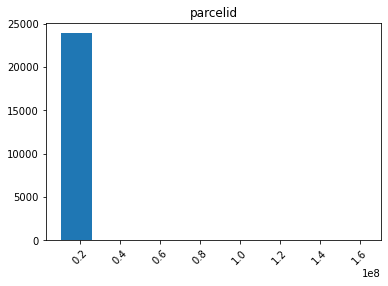

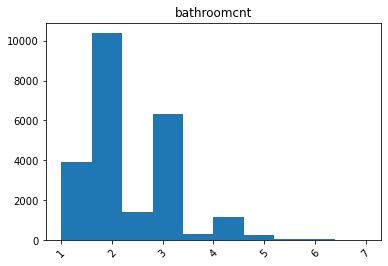

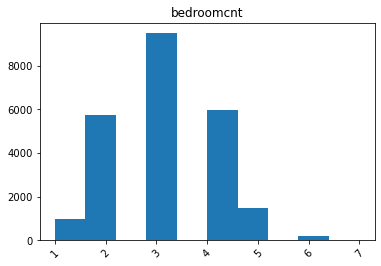

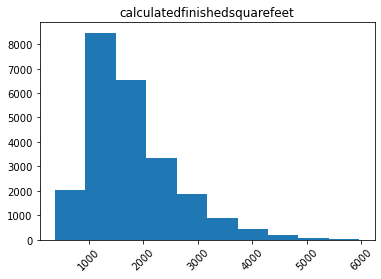

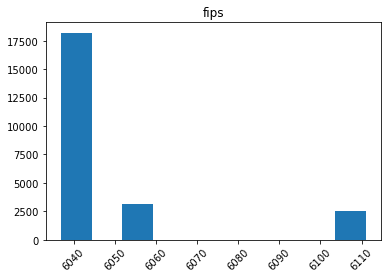

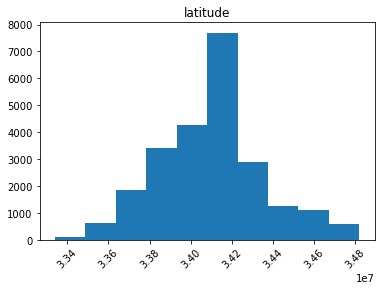

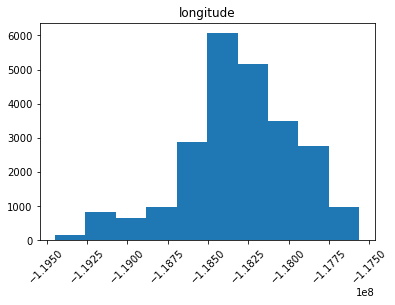

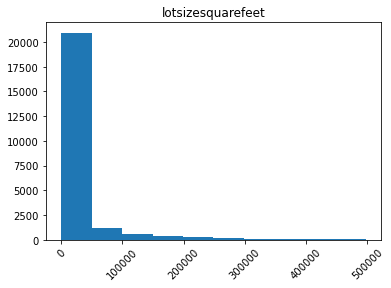

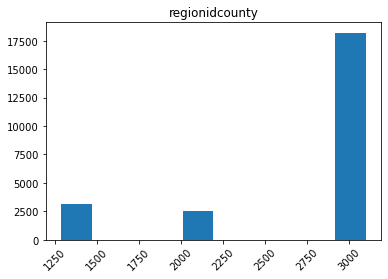

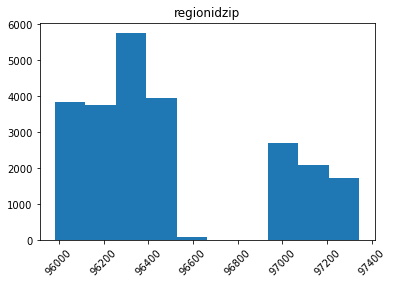

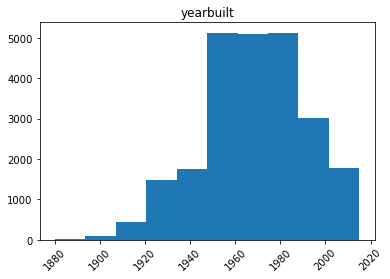

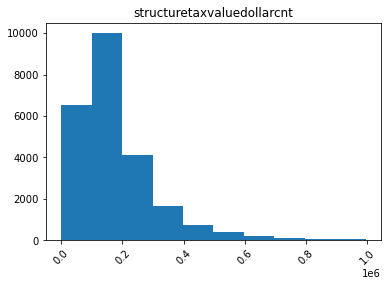

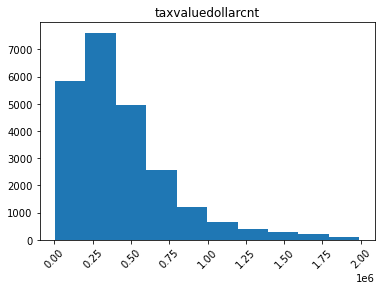

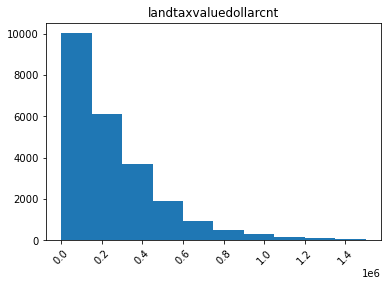

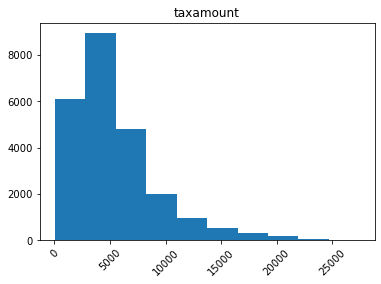

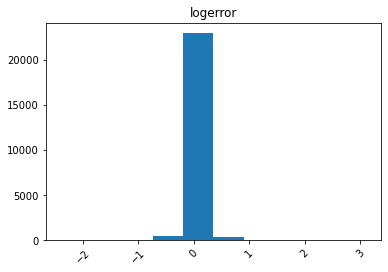

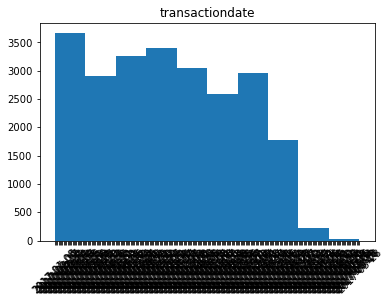

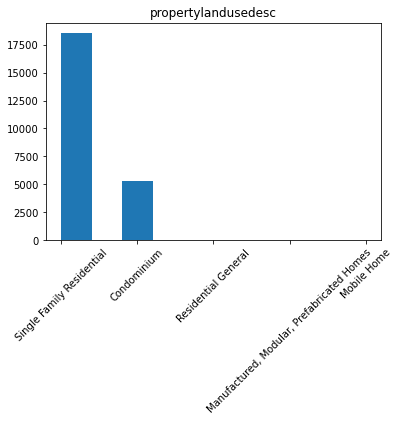

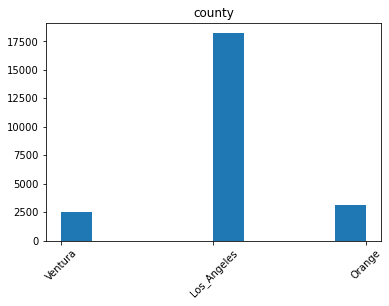

In [30]:
for col in train.columns:
    plt.hist(train[col])
    plt.title(col)
    plt.xticks(rotation=45)
    plt.show()

#### The histograms shows clean data. Heat map is not promising, the relationship with Log error is very low.

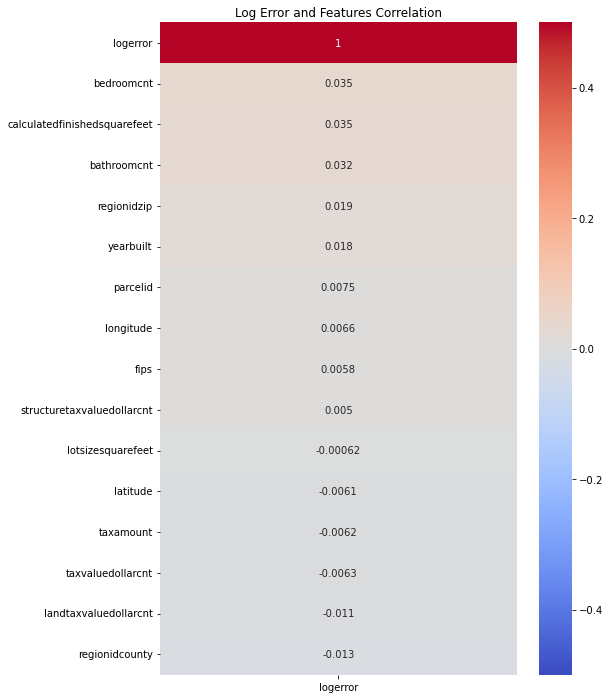

In [31]:
plt.figure(figsize=(8,12))
log_htmap = sns.heatmap(train.corr()[['logerror']].sort_values(by='logerror', ascending=False), cmap = 'coolwarm', vmin=-.5, vmax=.5, annot=True)
log_htmap.set_title('Log Error and Features Correlation')
plt.show()

#### There are a few correlations in the heatmap. Mainly with the value and size.

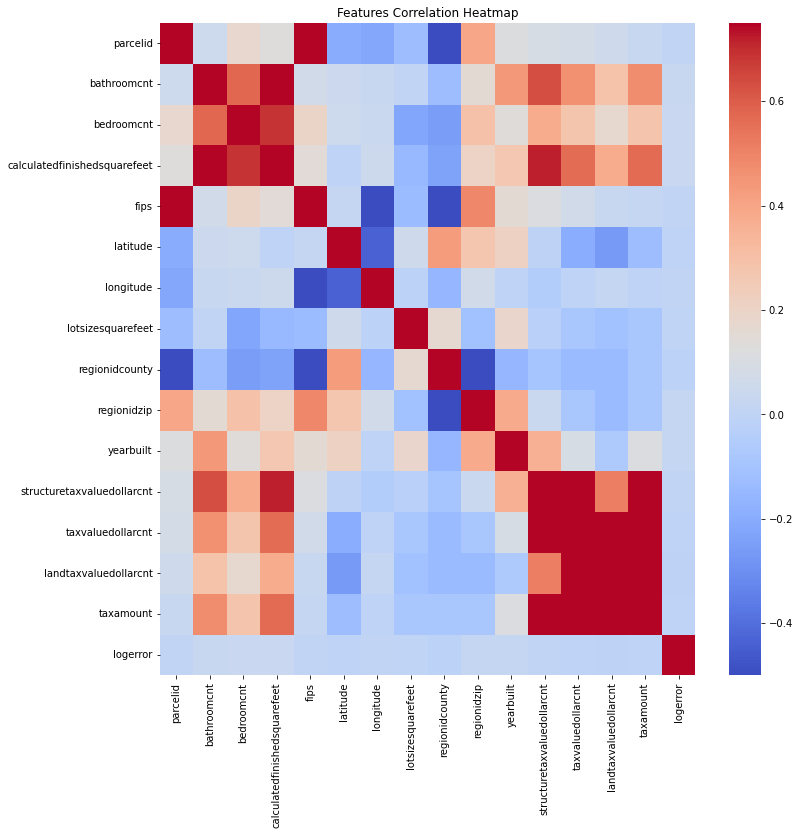

In [32]:
plt.figure(figsize=(12,12))
htmap = sns.heatmap(train.corr(), cmap = 'coolwarm', vmin=-.5, vmax=.75)
htmap.set_title('Features Correlation Heatmap')
plt.show()

## Exploratory Data Analysis

#### Q1. Is there a relationship between Log Error and Zip Code?

Relationship between Log Error and Zip Code


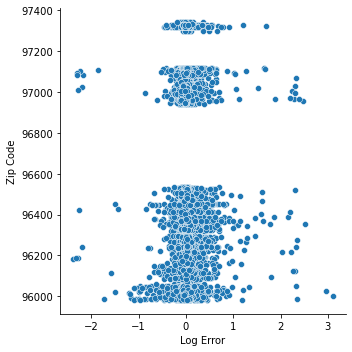

In [38]:
print('Relationship between Log Error and Zip Code')
sns.relplot(y='regionidzip', x='logerror', data=train)
plt.xlabel('Log Error')
plt.ylabel('Zip Code')
plt.show()

HO: There is no relation between Zip Code and Log Error
<p>
H⍺: There is a relation between Zip Code and Log Error

In [39]:
observed = pd.crosstab(train.logerror, train.regionidzip)

chi2, p, degf, expected = stats.chi2_contingency(observed)
print('Observed\n:')
print(observed.values)
print('------------------------\nExpected: \n')
print(expected.astype(int))
print('------------------------\n')
print(f'chi2 = {chi2:.2f}')
print(f'p value: {p:.4f}')
print(f'degrees of freedom: {degf}')
if (p < alpha):
    print("We reject the null hypothesis")
else:
    print("We fail to reject the null hypothesis")

Observed
:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
------------------------
Expected: 

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
------------------------

chi2 = 8981558.70
p value: 0.0172
degrees of freedom: 8972600
We reject the null hypothesis


#### Summary:
There is a correlation between Log Error and Zip Code

#### Q2. Is there a relationship between Log Error and Square Footage?

Relationship between Log Error and Square Footage


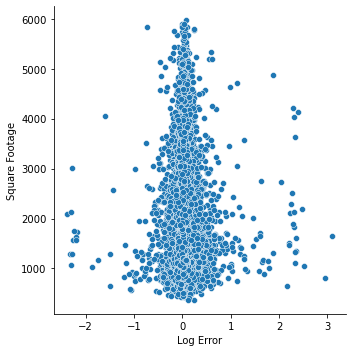

In [40]:
print('Relationship between Log Error and Square Footage')
sns.relplot(y='calculatedfinishedsquarefeet', x='logerror', data=train)
plt.xlabel('Log Error')
plt.ylabel('Square Footage')
plt.show()

HO: There is no relation between Square Footage and Log Error
<p>
H⍺: There is a relation between Square Footage and Log Error

In [41]:
observed = pd.crosstab(train.logerror, train.calculatedfinishedsquarefeet)

chi2, p, degf, expected = stats.chi2_contingency(observed)
print('Observed\n:')
print(observed.values)
print('------------------------\nExpected: \n')
print(expected.astype(int))
print('------------------------\n')
print(f'chi2 = {chi2:.2f}')
print(f'p value: {p:.4f}')
print(f'degrees of freedom: {degf}')
if (p < alpha):
    print("We reject the null hypothesis")
else:
    print("We fail to reject the null hypothesis")

Observed
:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
------------------------
Expected: 

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
------------------------

chi2 = 84801394.45
p value: 0.0001
degrees of freedom: 84751800
We reject the null hypothesis


#### Summary:
There is correlation between Log Error and Square Footage

#### Q3. Is there a relationship between Log Error and Tax Value?


Relationship between Log Error and Tax Value


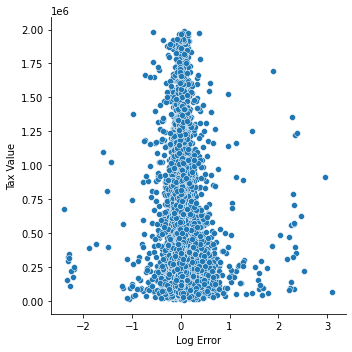

In [44]:
print('Relationship between Log Error and Tax Value')
sns.relplot(y='taxvaluedollarcnt', x='logerror', data=train)
plt.xlabel('Log Error')
plt.ylabel('Tax Value')
plt.show()

HO: There is no relation between Tax Value and Log Error
<p>
H⍺: There is a relation between Tax Value and Log Error

In [45]:
observed = pd.crosstab(train.logerror, train.taxvaluedollarcnt)

chi2, p, degf, expected = stats.chi2_contingency(observed)
print('Observed\n:')
print(observed.values)
print('------------------------\nExpected: \n')
print(expected.astype(int))
print('------------------------\n')
print(f'chi2 = {chi2:.2f}')
print(f'p value: {p:.4f}')
print(f'degrees of freedom: {degf}')
if (p < alpha):
    print("We reject the null hypothesis")
else:
    print("We fail to reject the null hypothesis")

Observed
:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
------------------------
Expected: 

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
------------------------

chi2 = 446271444.47
p value: 0.0650
degrees of freedom: 446226200
We fail to reject the null hypothesis


#### Summary:
We cannot reject the null hypothesis. We will continue to assert there is no significant relationship between Tax Value and Log Error

##### Q4. - Is there a relationship between Log Error and Latitude?

Relationship between Log Error and Latitude


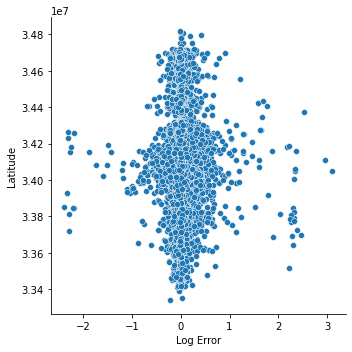

In [46]:
print('Relationship between Log Error and Latitude')
sns.relplot(y='latitude', x='logerror', data=train)
plt.xlabel('Log Error')
plt.ylabel('Latitude')
plt.show()

HO: There is no relation between Latitude and Log Error
<p>
H⍺: There is a relation between Latitude and Log Error

In [47]:
observed = pd.crosstab(train.logerror, train.latitude)

chi2, p, degf, expected = stats.chi2_contingency(observed)
print('Observed\n:')
print(observed.values)
print('------------------------\nExpected: \n')
print(expected.astype(int))
print('------------------------\n')
print(f'chi2 = {chi2:.2f}')
print(f'p value: {p:.4f}')
print(f'degrees of freedom: {degf}')
if (p < alpha):
    print("We reject the null hypothesis")
else:
    print("We fail to reject the null hypothesis")

Observed
:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
------------------------
Expected: 

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
------------------------

chi2 = 499027051.60
p value: 0.0287
degrees of freedom: 498967000
We reject the null hypothesis


### Summary:
We cannot reject the null hypothesis. We will continue to assert there is no significant relationship between Latitude and Log Error

## Clustering 

Scale the data using min-max scaler

In [50]:
mm_scaler, train_mm, validate_mm, test_mm = min_max_scaler(train, validate, test)

#### Cluster to help with question 1:

<AxesSubplot:xlabel='logerror', ylabel='regionidzip'>

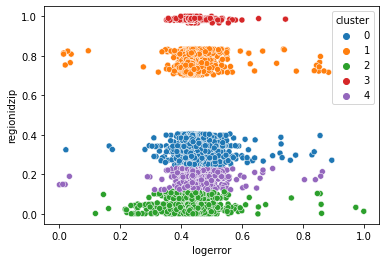

In [53]:
X = train_mm[['logerror', 'regionidzip']]

# Make the model
kmeans = KMeans(n_clusters=5)

# Fit the model
kmeans.fit(X)
kmeans.predict(X)

# add cluster column for visualization
train_mm['cluster'] = kmeans.predict(X)
train_mm.cluster = train_mm.cluster.astype('category')
train_mm.head()

# visualize the cluster
sns.scatterplot(data=train_mm, y = 'regionidzip', x = 'logerror', hue= 'cluster')

Elbow method to get the optimal amount of clusters

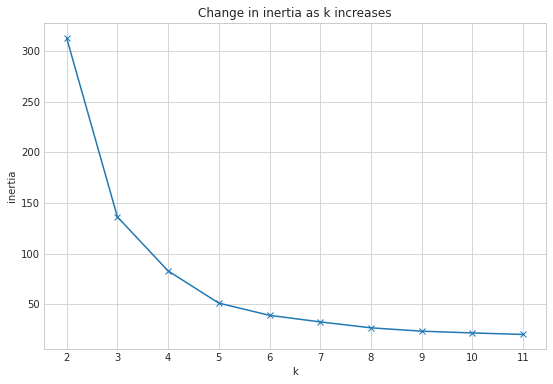

In [54]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

#### Cluster to help with question 2:

<AxesSubplot:xlabel='logerror', ylabel='calculatedfinishedsquarefeet'>

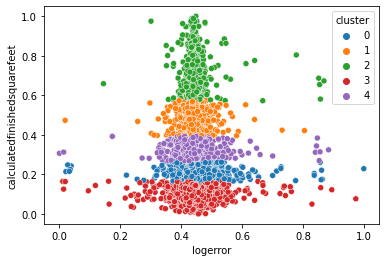

In [60]:
X = train_mm[['logerror', 'calculatedfinishedsquarefeet']]

# Make the model
kmeans = KMeans(n_clusters=5)

# Fit the model
kmeans.fit(X)
kmeans.predict(X)

# add cluster column for visualization
train_mm['cluster'] = kmeans.predict(X)
train_mm.cluster = train_mm.cluster.astype('category')
train_mm.head()

# visualize the cluster
sns.scatterplot(data=train_mm, y = 'calculatedfinishedsquarefeet', x = 'logerror', hue= 'cluster')

#### Cluster to help with question 3:

<AxesSubplot:xlabel='logerror', ylabel='taxvaluedollarcnt'>

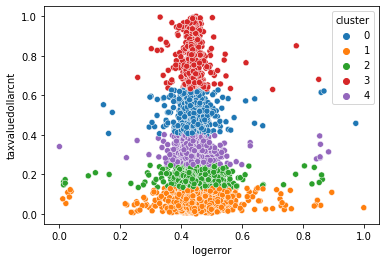

In [56]:
X = train_mm[['logerror', 'taxvaluedollarcnt']]

# Make the model
kmeans = KMeans(n_clusters=5)

# Fit the model
kmeans.fit(X)
kmeans.predict(X)

# add cluster column for visualization
train_mm['cluster'] = kmeans.predict(X)
train_mm.cluster = train_mm.cluster.astype('category')
train_mm.head()

# visualize the cluster
sns.scatterplot(data=train_mm, y = 'taxvaluedollarcnt', x = 'logerror', hue= 'cluster')

#### Cluster to help with question 4:

<AxesSubplot:xlabel='logerror', ylabel='latitude'>

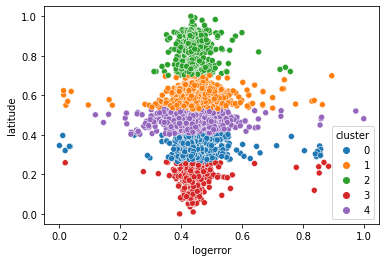

In [58]:
X = train_mm[['logerror', 'latitude']]

# Make the model
kmeans = KMeans(n_clusters=5)

# Fit the model
kmeans.fit(X)
kmeans.predict(X)

# add cluster column for visualization
train_mm['cluster'] = kmeans.predict(X)
train_mm.cluster = train_mm.cluster.astype('category')
train_mm.head()

# visualize the cluster
sns.scatterplot(data=train_mm, y = 'latitude', x = 'logerror', hue= 'cluster')

In [64]:
train_mm.drop(columns=['cluster'], inplace=True)

## Modeling

In [65]:
obj_cols = train_mm.columns[[train_mm[col].dtype == 'O'for col in train_mm.columns]]

train_mm = train_mm.drop(columns=obj_cols)
validate_mm = validate_mm.drop(columns=obj_cols)
test_mm = test_mm.drop(columns=obj_cols)

#### Create X and y variables

In [66]:
# Create X and Y variables
X_train = train_mm.drop(columns=['logerror'])
y_train = train_mm[['logerror']]

X_validate = validate_mm.drop(columns=['logerror'])
y_validate = validate_mm[['logerror']]

X_test = test_mm.drop(columns=['logerror'])
y_test = test_mm[['logerror']]

### Create a baseline

In [68]:
# We need y_train and y_validate to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

# 1. Predict logerror_mean
logerror_pred_mean = y_train['logerror'].mean()
y_train['logerror_pred_mean'] = logerror_pred_mean
y_validate['logerror_pred_mean'] = logerror_pred_mean

# 2. compute logerror_median
logerror_pred_median = y_train['logerror'].median()
y_train['logerror_pred_median'] = logerror_pred_median
y_validate['logerror_pred_median'] = logerror_pred_median

# 3. RMSE of logerror_pred_mean
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_mean)**(1/2)
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_mean)**(1/2)

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 4), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 4))

# 4. RMSE of logerror_pred_median
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_median)**(1/2)
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_median)**(1/2)

print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 4), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 4))

RMSE using Mean
Train/In-Sample:  0.0277 
Validate/Out-of-Sample:  0.0296
RMSE using Median
Train/In-Sample:  0.0277 
Validate/Out-of-Sample:  0.0297


Summary:

The baseline performance:

- RMSE using Mean
    - Train/In-Sample:  0.0277 
    - Validate/Out-of-Sample:  0.0296
- RMSE using Median
    - Train/In-Sample:  0.0277 
    - Validate/Out-of-Sample:  0.0297

Very low now let's see how our models do!

## Evaluation Metric

What did I use again?

## Models

Explanation

### Model 1: LassoLars

In [69]:
# create the model object
lars = LassoLars(alpha=1.0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lars.fit(X_train, y_train.logerror)

# predict train
y_train['logerror_pred_lars'] = lars.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_lars)**(1/2)

# predict validate
y_validate['logerror_pred_lars'] = lars.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lars)**(1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Lasso + Lars
Training/In-Sample:  0.027650611642392287 
Validation/Out-of-Sample:  0.029604955182387916


#### Summary:
Performed slightly better than baseline

### Model 2: TweedieRegressor (GLM)

In [70]:
# create the model object
glm = TweedieRegressor(power=1, alpha=0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train, y_train.logerror)

# predict train
y_train['logerror_pred_glm'] = glm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_glm)**(1/2)

# predict validate
y_validate['logerror_pred_glm'] = glm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_glm)**(1/2)

print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for GLM using Tweedie, power=1 & alpha=0
Training/In-Sample:  0.027616435646195245 
Validation/Out-of-Sample:  0.029577797160981315


#### Summary:
Performed slightly better than baseline

### Model 3 : Polinomial Features LM2

In [73]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate)
X_test_degree2 = pf.transform(X_test)

# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_degree2, y_train.logerror)

# predict train
y_train['logerror_pred_lm2'] = lm2.predict(X_train_degree2)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_lm2)**(1/2)

# predict validate
y_validate['logerror_pred_lm2'] = lm2.predict(X_validate_degree2)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lm2)**(1/2)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  0.0274992855667765 
Validation/Out-of-Sample:  0.031350433355608574


#### Summary:
Performed slightly worse than baseline

### Top model : LinearRegression (OLS)

In [74]:
# create the model object
lm = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm.fit(X_train, y_train.logerror)

# predict train
y_train['logerror_pred_lm'] = lm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_lm)**(1/2)

# predict validate
y_validate['logerror_pred_lm'] = lm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lm)**(1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  0.02760833457051546 
Validation/Out-of-Sample:  0.02956614862188652


#### Summary: 
Performed slightly better than baseline

### Test top model: OLS

In [75]:
y_test = pd.DataFrame(y_test)

# predict on test
y_test['logerror_pred_lm'] = lm.predict(X_test)

# evaluate: rmse
rmse_test = mean_squared_error(y_test.logerror, y_test.logerror_pred_lm)**(1/2)

print("RMSE for OLS Model using LinearRegression\nOut-of-Sample Performance: ", rmse_test)

RMSE for OLS Model using LinearRegression
Out-of-Sample Performance:  0.030717748645336516


## Conclusion

#### Summary

- The model was overwhelming. It performed slighlty better than the baseline
- Data had a lot of null values
- Dropped about half the data
- Clusters are a nice feature in this relationships

### Recommendations

- Data gathering will be a priority
- There is very low relationship between:
    - zip code and logerror
    - square footage and logerror
- Get more reliable information to see if we can improve the model

### Next Steps

- Gather more data try to close null gaps
- Combine some of the repetitive data
- With more time:
    - Cluster more variables
    - Cluster multiple variables